In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [2]:
print(tf.__version__)

2.3.1


In [3]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1.tar.gz", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

84131840/84125825 [==============================] - 121s 1us/step


In [4]:
os.listdir(dataset_dir)

['imdb.vocab', 'imdbEr.txt', 'README', 'test', 'train']

In [5]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['labeledBow.feat',
 'neg',
 'pos',
 'unsup',
 'unsupBow.feat',
 'urls_neg.txt',
 'urls_pos.txt',
 'urls_unsup.txt']

In [6]:
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
    print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


In [7]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [11]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size = batch_size,
    validation_split = 0.2,
    subset = 'training',
    seed = seed
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [12]:
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(3):
        print("Review", text_batch.numpy()[i])
        print("Label", label_batch.numpy()[i])

Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

In [14]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


In [17]:
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size = batch_size,
    validation_split = 0.2,
    subset = 'validation',
    seed = seed,
    shuffle = False
)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [18]:
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test',
    batch_size = batch_size
)

Found 25000 files belonging to 2 classes.


In [19]:
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    return tf.strings.regex_replace(stripped_html,
                                   '[%s]' % re.escape(string.punctuation),
                                   '')

In [20]:
max_features = 10000
sequence_length = 250

vectorize_layer = TextVectorization(
    standardize = custom_standardization,
    max_tokens = max_features,
    output_mode = 'int',
    output_sequence_length = sequence_length
)

In [21]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [26]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [28]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'Recipe for one of the worst movies of all time: a she-male villain who looks like it escaped from the WWF, has terrible aim with a gun that has inconsistent effects (the first guy she shoots catches on fire but when she shoots anyone else they just disappear) and takes time out to pet a deer. Then you got the unlikable characters, 30 year old college students, a lame attempt at a surprise ending and lots, lots more. Avoid at all costs.', shape=(), dtype=string)
Label neg
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[9249,   15,   28,    5,    2,  241,   91,    5,   30,   58,    4,
           1, 1013,   36,  262,   38,    9, 3923,   35,    2,    1,   43,
         382, 5216,   16,    4, 1115,   12,   43, 5734,  300,    2,   83,
         225,   55, 3208, 3934,   20,  978,   18,   51,   55, 3208,  250,
         320,   34,   40, 4381,    3,  294,   58,   44,    6, 2906,    4,
        6744,   92,   22,  184,    2, 4915,  100, 1221,  337,  161, 

In [29]:
print("776 ---> ",vectorize_layer.get_vocabulary()[776])
print("92 ---> ",vectorize_layer.get_vocabulary()[92])
print("0 ---> ",vectorize_layer.get_vocabulary()[0])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

776 --->  avoid
92 --->  then
0 --->  
Vocabulary size: 10000


In [30]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [31]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [32]:
embedding_dim = 16

In [33]:
model = tf.keras.Sequential([
    layers.Embedding(max_features + 1, embedding_dim),
    layers.Dropout(0.2),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.2),
    layers.Dense(1)])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160016    
_________________________________________________________________
dropout (Dropout)            (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


In [36]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
             optimizer='adam',
             metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

In [38]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
625/625 [==============================] - 80s 128ms/step - loss: 0.6636 - binary_accuracy: 0.6961 - val_loss: 0.6270 - val_binary_accuracy: 0.7558
Epoch 2/10
625/625 [==============================] - 3s 5ms/step - loss: 0.5483 - binary_accuracy: 0.8014 - val_loss: 0.5019 - val_binary_accuracy: 0.8318
Epoch 3/10
625/625 [==============================] - 4s 6ms/step - loss: 0.4452 - binary_accuracy: 0.8468 - val_loss: 0.4112 - val_binary_accuracy: 0.8636
Epoch 4/10
625/625 [==============================] - 4s 6ms/step - loss: 0.3787 - binary_accuracy: 0.8669 - val_loss: 0.3622 - val_binary_accuracy: 0.8742
Epoch 5/10
625/625 [==============================] - 4s 6ms/step - loss: 0.3365 - binary_accuracy: 0.8783 - val_loss: 0.3239 - val_binary_accuracy: 0.8860
Epoch 6/10
625/625 [==============================] - 4s 6ms/step - loss: 0.3061 - binary_accuracy: 0.8887 - val_loss: 0.3040 - val_binary_accuracy: 0.8938
Epoch 7/10
625/625 [==============================] - 4s 6ms/

In [39]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 216s 276ms/step - loss: 0.3108 - binary_accuracy: 0.8726
Loss:  0.3108177185058594
Accuracy:  0.8726400136947632


In [40]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

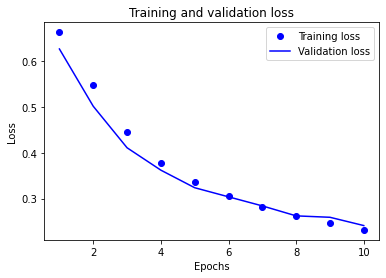

In [42]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc)+1)

#'bo' - blue dot
#'b'  - solid blue line

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

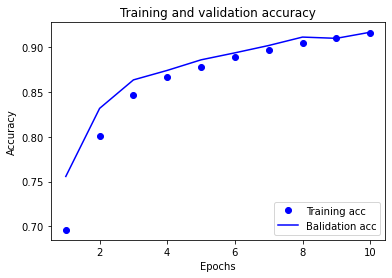

In [43]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Balidation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [44]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

In [45]:
export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)


In [46]:
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 20s 25ms/step - loss: 0.3108 - accuracy: 0.8726
0.8726400136947632


In [48]:
examples = ["The movie is bad.", "The film was fine."]

export_model.predict(examples)

array([[0.3758977],
       [0.5460406]], dtype=float32)

In [49]:
model.save('my_model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: my_model\assets
